# <center> Introduction to Machine learning 
## <center> BIO_322
## <center> Created by Mohammed Al-hussini and Nayan Adani

### Welcome machine learners !
##### Doing a machine learning project for the first time seems very difficult, because machine learning is a vast topic. There are so many things to explore, try, modify, add... To help you in this wonderful journey, we show you this notebook from a previous project. The project got grade 6 and ranked 2nd in the competition.

### Project Description :
Liquid chromatography is a method to detect drugs in human tissues and biofluids, for example, the cocaine concentration in urine. In a liquid chromatography experiment, each drug can be identified by its so-called retention time (RT). The retention time depends critically on the chemical properties of the drug and the exact configuration of the chromatography within a particular laboratory. For a new drug, the retention time can be measured experimentally by obtaining a clean sample of the new drug and directly measuring its retention time on the chromatography setup in a given laboratory. Alternatively, since the RT depends on the chemical structure, one could measure the retention time on one machine, determine the molecular structure of the new drug and predict the retention time on other machines based on the chemical features of the new drug. This is what we will do in this project. You are given the molecular structure of many drugs in the SMILES format together with the retention times measured in different laboratories, on different chromatography platforms. You can either use the SMILES notation directly or domain-specific features, like circular fingerprints or CDDD embeddings, to fit machine learning models that predict the retention times.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
from torch.utils.data import DataLoader
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, rdchem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import *
import optuna
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
import skorch
from skorch.helper import DataFrameTransformer
import warnings
from bayes_opt import BayesianOptimization
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import *
from sklearn.linear_model import *

# For reproductibility
my_seed = 42


In [1]:
def plot_comparison(data, names):
    sns.boxplot(data = pd.DataFrame({'neg_mean_squared_error': np.concatenate(data),
                                     'method': list(itertools.chain.from_iterable([[x]*len(y) for x, y in zip(names, data)]))}),
                x = 'method', y = 'neg_mean_squared_error')

# <center> I/ Loading, exploration and visualisation of the data,

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
df_train.shape

(3500, 1029)

In [5]:
df_test.shape

(1375, 1028)

In [6]:
df_train.head()

,Compound,SMILES,Lab,RT,mol,ECFP_1,ECFP_2,ECFP_3,ECFP_4,ECFP_5,...,ECFP_1015,ECFP_1016,ECFP_1017,ECFP_1018,ECFP_1019,ECFP_1020,ECFP_1021,ECFP_1022,ECFP_1023,ECFP_1024
0,Hydroxytriazolam,OCc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1Cl)=NC2,CFSRE,7.02,<rdkit.Chem.rdchem.Mol object at 0x2aab375ee880>,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5-MeO-DIPT,COc1ccc2[nH]cc(CCN(C(C)C)C(C)C)c2c1,Aarhus,4.45,<rdkit.Chem.rdchem.Mol object at 0x2aab37643680>,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,MDMA,CNC(C)Cc1ccc2c(c1)OCO2,Ghent University,3.14,<rdkit.Chem.rdchem.Mol object at 0x2aab378ea730>,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Despropionyl N-Benzyl para-Fluoro Norfentanyl,Fc1ccc(NC2CCN(Cc3ccccc3)CC2)cc1,San Francisco OCME,5.95,<rdkit.Chem.rdchem.Mol object at 0x2aab3790f3e0>,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,N-Ethylpentylone,CCCC(NCC)C(=O)c1ccc2c(c1)OCO2,Ghent University,4.21,<rdkit.Chem.rdchem.Mol object at 0x2aab378eadc0>,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Display the column names
print("Column names :")
print(df_test.columns)

# Count the number of columns starting with "ECFP"
ecfp_columns = [col for col in df_test.columns if col.startswith('ECFP')]
ecfp_count = len(ecfp_columns)

print(f"Number of ECFP columns : {ecfp_count}")

Column names :
Index(['Compound', 'SMILES', 'Lab', 'mol', 'ECFP_1', 'ECFP_2', 'ECFP_3',
       'ECFP_4', 'ECFP_5', 'ECFP_6',
       ...
       'ECFP_1015', 'ECFP_1016', 'ECFP_1017', 'ECFP_1018', 'ECFP_1019',
       'ECFP_1020', 'ECFP_1021', 'ECFP_1022', 'ECFP_1023', 'ECFP_1024'],
      dtype='object', length=1028)
Number of ECFP columns : 1024


In [8]:
# Find SMILES repeated more than 10 times
smiles_counts = df_train['SMILES'].value_counts()
smiles_repeated = smiles_counts[smiles_counts > 10].index

# Calculate the number of unique compounds for each repeated SMILES
unique_compounds_per_smiles = df_train[df_train['SMILES'].isin(smiles_repeated)].groupby('SMILES')['Compound'].nunique()

df_train[df_train['SMILES'].isin(smiles_repeated)].groupby('SMILES')[['Compound']].agg(['unique'])

,Compound
,unique
SMILES,
CCC1CN2CCc3c([nH]c4cccc(OC)c34)C2CC1C(=COC)C(=O)OC,"[Mitragynine, Speciogynine (Mitragyna alkaloid)]"
CCCC(C(=O)c1ccc2c(c1)OCO2)N1CCCC1,"[MDPV, 3,4-Methylenedioxypyrovalerone, 3,4-MDP..."
CCCC(NC)C(=O)c1ccccc1,[Pentedrone]
CNC(C)C(=O)c1ccc(C)cc1,"[Mephedrone, 4-MMC, mephedrone]"
CNC(C)C(=O)c1ccc2c(c1)OCO2,"[Methylone, Methylone (MDMC), bk-MDMA]"
CNC(C)Cc1ccc(OC)cc1,"[PMMA, PMMA (para-Methoxy-N-methylamphetamine)..."
COC(=O)C(NC(=O)c1nn(CCCCCF)c2ccccc12)C(C)(C)C,"[5F-MDMB-PINACA, 5F-ADB, 5F-ADB (5F-MDMB-PINAC..."
Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1F)=NC2,[Flualprazolam]


#### Observation
It looks like the description in the 'Compound' column is not used consistently: the same substance has different names. Sometimes differences are tiny, such as uppercase and lowercase (e.g. fourth row above), sometimes acronyms are used. Overall, we conclude that the 'Compound' column is not useful.

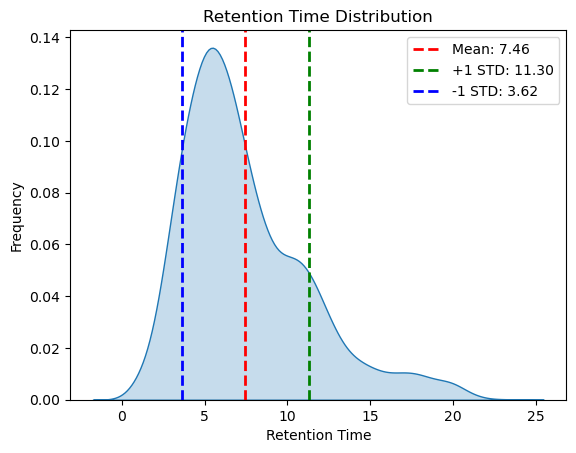

In [9]:
# Calculate mean and standard deviation
mean_rt = df_train['RT'].mean()
std_rt = df_train['RT'].std()
#median_rt = df_train['RT'].median()

# Create histogram
sns.kdeplot(data = df_train, x = 'RT', fill = True)
plt.title('Retention Time Distribution')
plt.xlabel('Retention Time')
plt.ylabel('Frequency')

# Add a vertical line for the mean
plt.axvline(mean_rt, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_rt:.2f}')

# Add vertical lines for one standard deviation above and below the mean
plt.axvline(mean_rt + std_rt, color='green', linestyle='dashed', linewidth=2, label=f'+1 STD: {mean_rt + std_rt:.2f}')
plt.axvline(mean_rt - std_rt, color='blue', linestyle='dashed', linewidth=2, label=f'-1 STD: {mean_rt - std_rt:.2f}')

# plt.axvline(median_rt, color='purple', linestyle='dashed', linewidth=2, label=f'Median: {median_rt:.2f}')


# Add a legend
plt.legend()
# Show plot

#### Observation

The retention time distribution is not symmetric, but it is positively skewed. This is not surprising, given that the retention time is a positive number. Maybe a log-transformation of the retention time would make sense, but we would have to carefully test this for each model, for example with cross-validation. Nevertheless, we check if the log of the retention time is closer to normally distributed:

In [10]:
# Create a new DataFrame with the same data as df_train
df_log_train = df_train.copy()

# Modify the 'retention_time' column by applying the logarithmic transformation
df_log_train['RT'] = np.log(df_log_train['RT'])


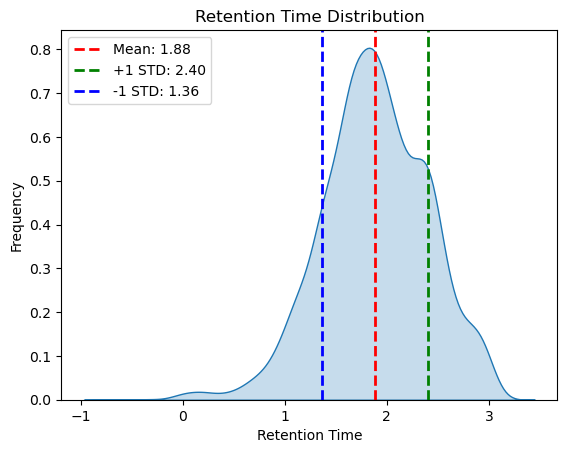

In [11]:
# Calculate mean and standard deviation
mean_rt = df_log_train['RT'].mean()
std_rt = df_log_train['RT'].std()
#median_rt = df_train['RT'].median()

# Create histogram
sns.kdeplot(data = df_log_train, x = 'RT', fill = True)
plt.title('Retention Time Distribution')
plt.xlabel('Retention Time')
plt.ylabel('Frequency')

# Add a vertical line for the mean
plt.axvline(mean_rt, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_rt:.2f}')

# Add vertical lines for one standard deviation above and below the mean
plt.axvline(mean_rt + std_rt, color='green', linestyle='dashed', linewidth=2, label=f'+1 STD: {mean_rt + std_rt:.2f}')
plt.axvline(mean_rt - std_rt, color='blue', linestyle='dashed', linewidth=2, label=f'-1 STD: {mean_rt - std_rt:.2f}')

# plt.axvline(median_rt, color='purple', linestyle='dashed', linewidth=2, label=f'Median: {median_rt:.2f}')


# Add a legend
plt.legend()
# Show plot

#### Observation
As expected, we obtain a more symmetric distribution. Nevertheless, it is still far from a Gaussian distribution. Note that we cannot conclude too much just from looking at the distribution of retention times (see e.g. [here](https://bio322.epfl.ch/notebooks/transformations.html#07734386-6858-46ab-9ce7-9e4092cb7280)). In the end, we won't use the log-transformation, and focus a lot on non-linear methods to obtain the best predictions.

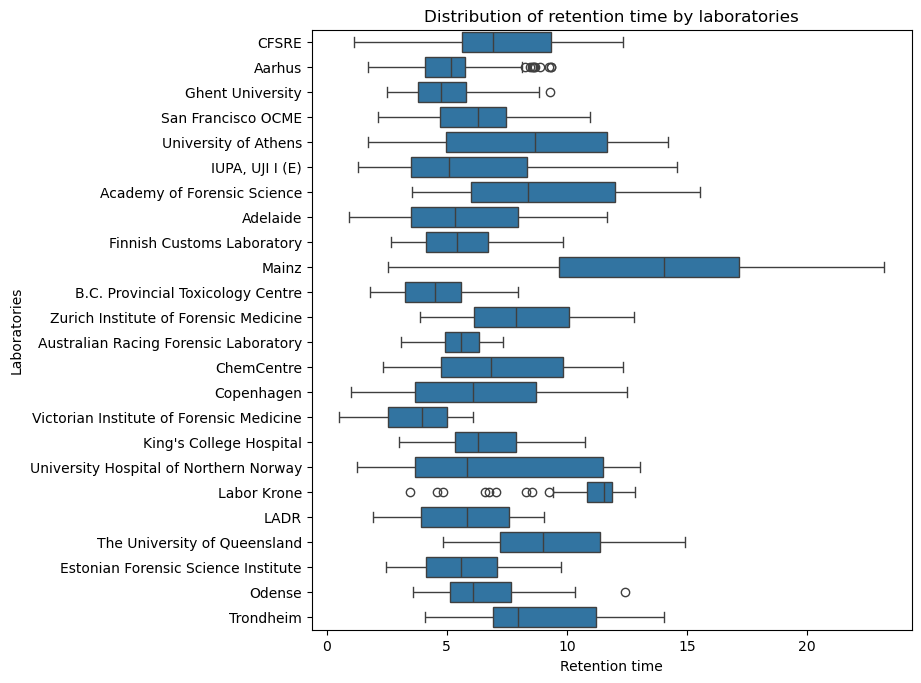

In [12]:
# Define the size of the chart
plt.figure(figsize=(10, 10)) 

# Create a boxplot with different colors for each 'lab'
sns.boxplot(x='RT', y='Lab', data=df_train)

# Adjust margins if necessary
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8)

plt.title('Distribution of retention time by laboratories')
plt.xlabel('Retention time')
plt.ylabel('Laboratories')
plt.show()

#### Observation
The distributions of retention times vary a lot from lab to lab. This means that it is probably a good idea to use the lab information in some way when trying to predict the retention time.

Here, we can observe an outlier: Mainz. Indeed, the retention times measured in this lab seem to be higher than the ones measured in other labs. The question is the following: Is it a good idea to delete the row with lab == 'Mainz' ? To answer this question, let's do more plots.

Number of unique Labs: 24


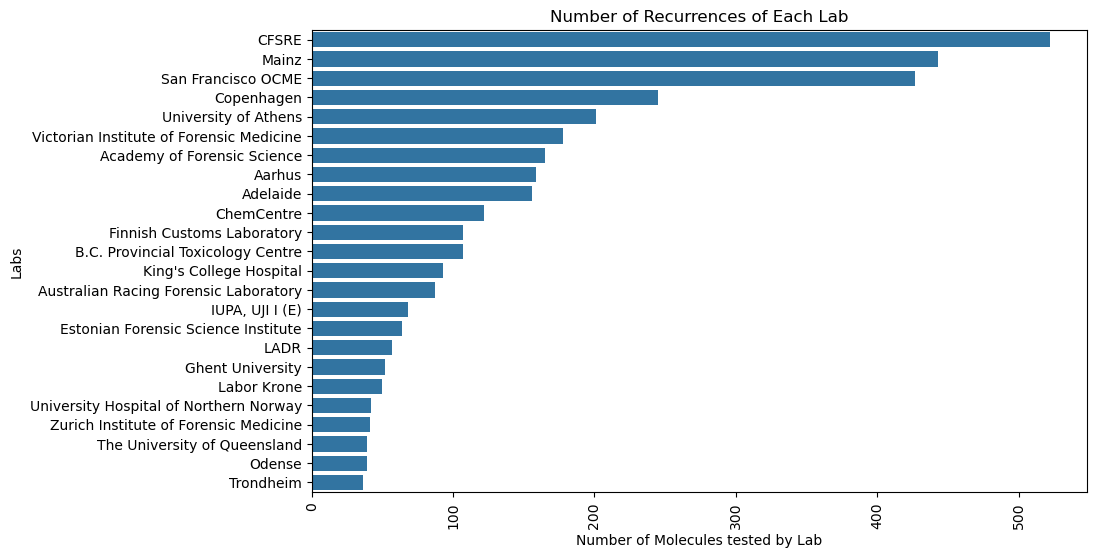

In [13]:
unique_Lab_count = df_train['Lab'].nunique()
print(f"Number of unique Labs: {unique_Lab_count}")
lab_counts = df_train['Lab'].value_counts()
plt.figure(figsize=(10, 6))  # Adjust the size as needed
sns.barplot(y=lab_counts.index, x=lab_counts.values)
plt.ylabel('Labs')
plt.xlabel('Number of Molecules tested by Lab')
plt.title('Number of Recurrences of Each Lab')
plt.xticks(rotation=90)  # Rotate the labels for better readability
plt.show()

#### Observation
We note that Mainz is the laboratory with the second largest number of molecules tested.



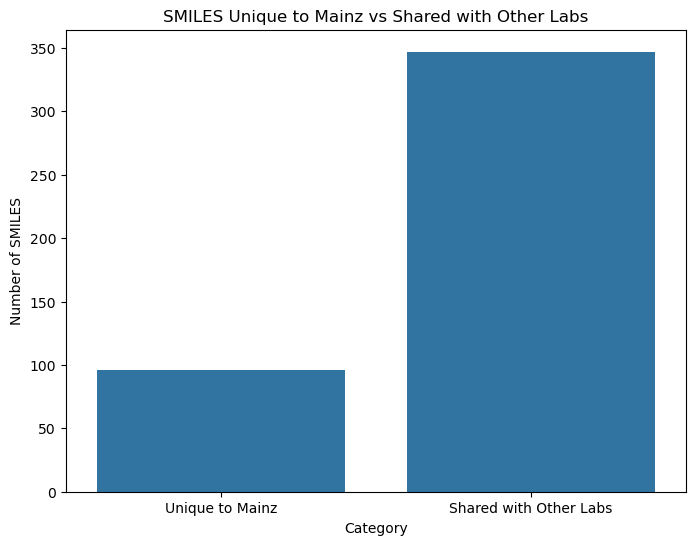

In [14]:
# Filter the DataFrame for Mainz lab and other labs
mainz_lab_smiles = df_train[df_train['Lab'] == 'Mainz']['SMILES']
other_labs_smiles = df_train[df_train['Lab'] != 'Mainz']['SMILES']

# Identification of unique SMILES in Mainz and shared ones
unique_to_mainz_smiles = mainz_lab_smiles[~mainz_lab_smiles.isin(other_labs_smiles)]
shared_smiles = mainz_lab_smiles[mainz_lab_smiles.isin(other_labs_smiles)]

# Counting unique and shared SMILES
unique_to_mainz_count = unique_to_mainz_smiles.nunique()
shared_smiles_count = shared_smiles.nunique()

# Preparing data for the chart
comparison_data = pd.DataFrame({
    'Category': ['Unique to Mainz', 'Shared with Other Labs'],
    'Count': [unique_to_mainz_count, shared_smiles_count]
})

# Create graph
plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Count', data=comparison_data)
plt.ylabel('Number of SMILES')
plt.title('SMILES Unique to Mainz vs Shared with Other Labs')
plt.show()

#### Observation
In the previous graph, we noted that Mainz was the lab with the second-highest number of molecules tested. In this graph, we see that almost 1 molecule out of 4.5 is unique to Mainz. Therefore, we conclude that removing the lines with Mainz is not a good idea, as we would lose too much information. In fact, removing data points (rows in the dataframe) is almost never a good idea, unless it is crystal clear that the removal would only remove noise and not any signal. It is probably better to use the lab information as a categorical predictor.

Number of unique SMILES: 1318
Number of repeated SMILES: 770


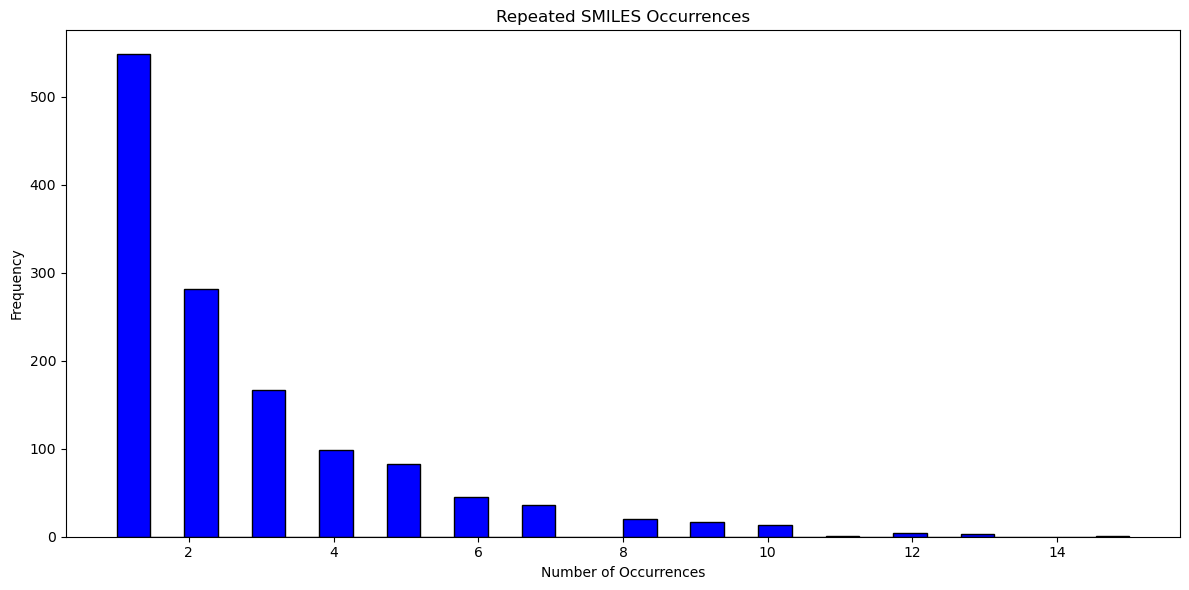

In [15]:
# Count the number of unique SMILES
unique_smiles_count = df_train['SMILES'].nunique()
print(f"Number of unique SMILES: {unique_smiles_count}")

# Find the repeated SMILES
smiles_counts = df_train['SMILES'].value_counts()
repeated_smiles = smiles_counts[smiles_counts > 1]
print(f"Number of repeated SMILES: {len(repeated_smiles)}")
#print("Repeated SMILES strings and their counts:")
#print(repeated_smiles)

# Count the occurrences of each SMILES string
smiles_counts = df_train['SMILES'].value_counts()

# Separate unique and repeated SMILES
unique_smiles = smiles_counts[smiles_counts == 1]
repeated_smiles = smiles_counts[smiles_counts >= 1]

# Plotting histograms
plt.figure(figsize=(12, 6))

# Histogram for repeated SMILES
plt.subplot(1, 1, 1)  # 1 row, 2 columns, second subplot
plt.hist(repeated_smiles, bins=30, color='blue', edgecolor='black')
plt.title('Repeated SMILES Occurrences')
plt.xlabel('Number of Occurrences')
plt.ylabel('Frequency')

# Show plot
plt.tight_layout()
plt.show()

We observe that most SMILES appear only once in the data set, but there are few SMILES that are measured multiple times (up to 15 times).

# <center> II/ preprocessing, cleaning and feature engineering,

##### After adding data (cddd or molecular property), performing one-hot encoding, handling nan, checking the correlation between features and if there are constant features, we remove the least important features using random forest. Indeed, we had a lot of molecule information (a lot of ECFP and cddd) and some was useless. Therefore, our model can devote all its energy to learning the relevant features. Of course, the number of features removed is a hyperparameter. We show in the section on Random forests that our feature engineering strategy is useful.


In [16]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [17]:
def rand_forest(df_train, select, thresh):

    # We select only the features that we want to study
    if select == 'ECFP' :
        X_train = df_train.iloc[:, 1:1024]
        y_train = df_train[['RT']].squeeze()

    elif select == 'cddd' :
            X_train = df_train.iloc[:,1024 :1589]
            y_train = df_train[['RT']].squeeze()

    else : print('error select must be equal to ECFP or cddd')

    # Create and train random forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=my_seed) 
    rf_model.fit(X_train, y_train)

    # We select features depending on their importances
    sfm = SelectFromModel(rf_model, threshold=thresh)

    # we get the index of the unwanted features
    feature_indices = ~sfm.get_support()

    # we obtain the names of the unwanted features
    dropped_feature_names = X_train.columns[feature_indices]
   
    return dropped_feature_names



def merge_cddd(df1):
    df2 = pd.read_csv('cddd.csv')
    # left keep all df1 row and delete the non corresponding df2's ones
    df_merged = pd.merge(df1, df2, on='SMILES', how='left')
    
    # We replace the nan by 0
    df_merged = df_merged.fillna(0)

    return df_merged



def smiles_to_descriptors(smiles):

    try:

        mol = Chem.MolFromSmiles(smiles)

        if mol:

            logp = Descriptors.MolLogP(mol) # LogP (coefficient de partage octanol/eau).

            molwt = Descriptors.MolWt(mol) # MOLWT Poids moléculaire

            return logp, molwt

        else:

            return float('nan'), float('nan')

    except:

        return float('nan'), float('nan')


In [18]:
def processing(df_train, df_test, threshold):
    
    
    # add cddd to the dataframes
    df_train = merge_cddd(df_train)
    df_test = merge_cddd(df_test)
    
    # We use rdkit library to add the molecular weights and log P of all molecules thanks to the SMILES
    df_train[['LogP', 'MolWt']] = df_train['SMILES'].apply(lambda x: pd.Series(smiles_to_descriptors(x)))
    df_test[['LogP', 'MolWt']] = df_test['SMILES'].apply(lambda x: pd.Series(smiles_to_descriptors(x)))

    # We drop the unwanted features
    df_train = df_train.drop(['mol', 'SMILES', 'Compound'], axis=1)
    df_test = df_test.drop(['mol', 'SMILES', 'Compound'], axis=1)

    # We transform lab in one's hot encoding
    df_train= pd.get_dummies(df_train, columns=['Lab'])
    df_test= pd.get_dummies(df_test, columns=['Lab'])

    # We use the rand_forest function in a way to remove useless ECFP and useless cddd
    drop_ECFP_name = rand_forest(df_train, 'ECFP', threshold)
    drop_cddd_name = rand_forest(df_train, 'cddd', threshold)

    df_train = df_train.drop(columns=drop_ECFP_name)
    df_train = df_train.drop(columns=drop_cddd_name)
    df_test = df_test.drop(columns=drop_ECFP_name)
    df_test = df_test.drop(columns=drop_cddd_name)
     
    # Now we want to remove correlated features
    # Compute the correlation matrix
    corr_matrix = df_train.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

    # Find index of feature columns with correlation greater than 0.8 or 0.9
    to_drop = [column for column in upper.columns if any(upper[column]> 0.97)]

    # Drop features 
    df_train = df_train.drop(columns=to_drop)
    df_test = df_test.drop(columns=to_drop)

    return df_train, df_test



df_process_train, df_process_test = processing(df_train, df_test, 1.32476761374679e-5) 


# <center> III/ Training and tuning a linear method, e.g. with regularisation

In [19]:
X_train = df_process_train.drop('RT', axis=1)
y_train = df_process_train['RT']
X_test = df_process_test

In [20]:
# Ignore non-convergence warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Generic Bayesian optimization function
def optimize_model(model_class, param_bounds, model_params, cv_params):
    def cv_score(**params):
        model = model_class(**{**model_params, **params})
        cv_score = cross_val_score(model, **cv_params)
        return np.mean(cv_score)

    optimizer = BayesianOptimization(f=cv_score, pbounds=param_bounds, random_state=42)
    optimizer.maximize(init_points=10, n_iter=10)
    return optimizer.max['params']

# Cross-validation parameters
cv_params = {'X': X_train, 'y': y_train, 'cv': 5, 'scoring': 'neg_mean_squared_error'}

## Optimization for Lasso
params_lasso = {'alpha': (0.00001, 1)}
best_params_lasso = optimize_model(Lasso, params_lasso, {'max_iter': 1000}, cv_params)
print("Best parameters for Lasso: ", best_params_lasso)
#
## Optimization for Bayesian Ridge
params_bayesian_ridge = {'alpha_1': (1e-6, 1e-3), 'alpha_2': (1e-6, 1e-3), 'lambda_1': (1e-6, 1e-3), 'lambda_2': (1e-6, 1e-3)}
best_params_bayesian_ridge = optimize_model(BayesianRidge, params_bayesian_ridge, {}, cv_params)
print("Best parameters for Bayesian Ridge: ", best_params_bayesian_ridge)

# Define the grid parameters
param_grid_omp = {'n_nonzero_coefs': range(1, 100, 5)}  # Par exemple, tester de 100 à 10000 par pas de 100
# Initialize the model
omp_model = OrthogonalMatchingPursuit()
# Initialize GridSearchCV
grid_search_omp = GridSearchCV(omp_model, param_grid_omp, cv=5, scoring='neg_mean_squared_error')
# Start gridsearch
grid_search_omp.fit(X_train, y_train)
# Retrieve the best settings and the best score
best_params_omp = grid_search_omp.best_params_
best_score_omp = grid_search_omp.best_score_
print("Best parameters for OrthogonalMatchingPursuit: ", best_params_omp)
print("Best score (neg_mean_squared_error): ", best_score_omp)

|   iter    |  target   |   alpha   |
-------------------------------------
| 1         | -5.169    | 0.3745    |
| 2         | -9.643    | 0.9507    |
| 3         | -9.14     | 0.732     |
| 4         | -7.47     | 0.5987    |
| 5         | -3.33     | 0.156     |
| 6         | -3.33     | 0.156     |
| 7         | -2.254    | 0.05809   |
| 8         | -9.51     | 0.8662    |
| 9         | -7.498    | 0.6011    |
| 10        | -8.845    | 0.7081    |
| 11        | -2.591    | 2.163e-05 |
| 12        | -2.059    | 0.04228   |
| 13        | -4.165    | 0.2556    |
| 14        | -1.887    | 0.03022   |
| 15        | -6.026    | 0.4655    |
| 16        | -2.772    | 0.1062    |
| 17        | -1.739    | 0.02244   |
| 18        | -4.631    | 0.3117    |
| 19        | -3.761    | 0.2038    |
| 20        | -1.626    | 0.01693   |
Best parameters for Lasso:  {'alpha': np.float64(0.016933570836199577)}
|   iter    |  target   |  alpha_1  |  alpha_2  | lambda_1  | lambda_2  |
------------------

In [21]:
# Instantiate ElasticNet with best settings
model_Lasso_net = Lasso(**best_params_lasso, max_iter=1000)


# Instantiate OrthogonalMatchingPursuit with best parameters

# Make sure 'n_nonzero_coefs' is an integer

n_nonzero_coefs = int(best_params_omp['n_nonzero_coefs']) if 'n_nonzero_coefs' in best_params_omp else 100

model_omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)



# Instantiate BayesianRidge with best parameters

model_bayesian_ridge = BayesianRidge(**best_params_bayesian_ridge)



model_Lasso_net.fit(X_train, y_train)

model_omp.fit(X_train, y_train)

model_bayesian_ridge.fit(X_train, y_train)

BayesianRidge(alpha_1=np.float64(4.687320311687288e-05),
              alpha_2=np.float64(0.0008919202555759458),
              lambda_1=np.float64(0.0009976820342492425),
              lambda_2=np.float64(7.972619213876703e-06))

To compare the models, we will use 5-fold cross-validation on the training data. Note that this will probably lead to a slightly biased estimate of the test error, because the hyperparameters were tuned with cross-validation on the same data. However, we do not care much about an accurate and unbiased estimate of the test error here, but we would like to select the overall best model.

In [22]:
bayes_ridge_score = cross_val_score(model_bayesian_ridge, X_train, y_train, scoring = 'neg_mean_squared_error')

In [23]:
lasso_score = cross_val_score(model_Lasso_net, X_train, y_train, scoring = 'neg_mean_squared_error')

In [24]:
omp_score = cross_val_score(model_omp, X_train, y_train, scoring = 'neg_mean_squared_error')

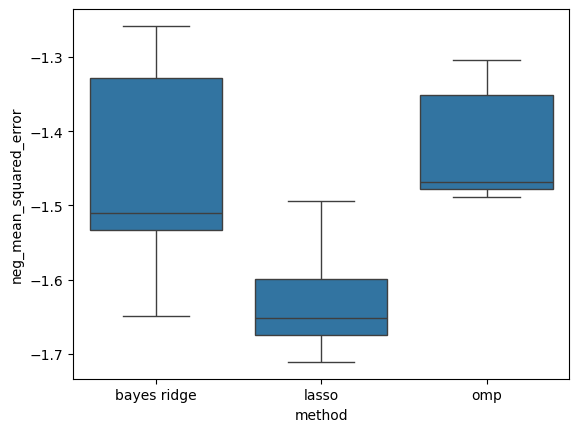

In [25]:
plot_comparison((bayes_ridge_score, lasso_score, omp_score), ("bayes ridge", "lasso", "omp")) # see function at the top

It looks like the tuned lasso is clearly worse than the other two methods.

# <center> IV/ Training and tuning of non-linear methods

# Random forest

##### Here we try a first "simple" nonlinear method. Random forest usually gives quite good results and can be a good way to check if other more advanced methods work well, by comparing their results with those of random forest.

In [26]:
rf_model = RandomForestRegressor(n_estimators=100, random_state = 42)

rf_score = cross_val_score(rf_model, X_train, y_train, scoring = 'neg_mean_squared_error')

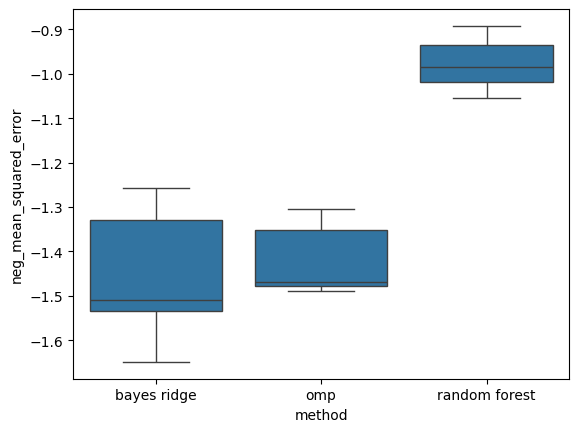

In [27]:
plot_comparison((bayes_ridge_score, omp_score, rf_score), ("bayes ridge", "omp", "random forest"))

Random forests are clearly much better than linear methods, even without any hyperparameter tuning. This is a clear indicator that a non-linear method is needed for an accurate fit.

Because the Random Forests are fast to train, we used them also to justify our preprocessing and feature selection pipeline.

In [28]:
tmp_df_train = df_train.drop(['mol', 'SMILES', 'Compound', 'RT'], axis=1)
tmp_df_train = pd.get_dummies(tmp_df_train, columns=['Lab'])
rf_score_no_preprocessing = cross_val_score(rf_model, tmp_df_train, y_train, scoring = 'neg_mean_squared_error')

In [29]:
tmp_df_train_cddd = merge_cddd(df_train)
tmp_df_train_cddd = tmp_df_train_cddd.drop(['mol', 'SMILES', 'Compound', 'RT'], axis=1)
tmp_df_train_cddd = pd.get_dummies(tmp_df_train_cddd, columns=['Lab'])
rf_score_with_cddd = cross_val_score(rf_model, tmp_df_train_cddd, y_train, scoring = 'neg_mean_squared_error')

In [30]:
tmp_df_train_cddd_rdkit = merge_cddd(df_train)
tmp_df_train_cddd_rdkit[['LogP', 'MolWt']] = tmp_df_train_cddd_rdkit['SMILES'].apply(lambda x: pd.Series(smiles_to_descriptors(x)))
tmp_df_train_cddd_rdkit = tmp_df_train_cddd_rdkit.drop(['mol', 'SMILES', 'Compound', 'RT'], axis=1)
tmp_df_train_cddd_rdkit = pd.get_dummies(tmp_df_train_cddd_rdkit, columns=['Lab'])
rf_score_with_cddd_rdkit = cross_val_score(rf_model, tmp_df_train_cddd_rdkit, y_train, scoring = 'neg_mean_squared_error')

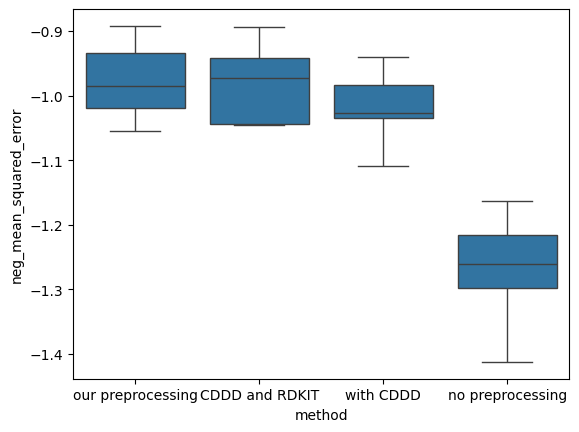

In [31]:
plot_comparison((rf_score, rf_score_with_cddd_rdkit, rf_score_with_cddd, rf_score_no_preprocessing),
                ("our preprocessing", "CDDD and RDKIT", "with CDDD", "no preprocessing"))

In [32]:
print("Input shape of CDDD + RDKIT preprocessing:", tmp_df_train_cddd_rdkit.shape)
print("Input shape of our preprocessing:", X_train.shape)

Input shape of CDDD + RDKIT preprocessing: (3500, 1562)
Input shape of our preprocessing: (3500, 1522)


Adding CDDD and RDKit Features clearly helps. Reducing the dimensionality slightly (from 1562 features to 1522) with our feature selection method, may help speed up training a bit, without reducing performance significantly.

# Neural Networks

##### Now let’s move on to the most interesting part (in our point of view): the neural network !

##### In the course, we learned that all functions can be fitted by a neural network, but that doesn’t mean it’s always the best model. For example, if there is too little data, the neural network can’t learn well and the random forest can be a better model. So we first tried the neural network with a random architecture and random hyperparameters. At first, the results were not excellent. Then by manually testing different architectures and hyperparameter configurations, we finally got encouraging results. We quickly realized that we had to put a lot of energy into this part, and we designed a more sophisticated tuning with a Bayesian search and some creative tricks like multiplying by a hyperparameter the one-hot coded lab feature, because we think it’s a very important feature.

In [33]:
from torch.utils.data import Dataset, DataLoader
import torch

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        row_X = self.X.iloc[idx]
        row_y = self.y.iloc[idx]
        x = torch.tensor(row_X, dtype=torch.float)
        y = torch.tensor(row_y, dtype=torch.float)
        return x, y


In [34]:
# hyperparameters
num_epochs = 90
batch_size = 32

In [35]:
# Network

class Network(nn.Module):
    def __init__(self, N_init, N1, N2, N3, N4):
        super(Network, self).__init__()
        self.linear1 = nn.Linear(N_init, N1)
        self.linear2 = nn.Linear(N1, N2)
        self.linear3 = nn.Linear(N2, N3)
        self.linear4 = nn.Linear(N3, N4)
        self.linear5 = nn.Linear(N4, 1)  # output : 1 for Retention time

    def forward(self,x):
        z = F.selu(self.linear1(x))
        z = F.selu(self.linear2(z))
        z = F.selu(self.linear3(z))
        z = F.selu(self.linear4(z))
        z = self.linear5(z)
        return z

class EarlyStopTraining:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, loss, model):
        if self.best_loss is None:
            self.best_loss = loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0



In [36]:
## loss
def loss(y_pred, y_hat):
    return torch.sqrt(torch.mean((y_pred - y_hat) ** 2))

In [37]:
# Ignore FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Objective function for Bayesian optimization
def objective(trial):
    # Hyperparameter Suggestion
    N1 = trial.suggest_int('N1', 80, 170)
    N2 = trial.suggest_int('N2', 50, 120)
    N3 = trial.suggest_int('N3', 20, 80)
    N4 = trial.suggest_int('N4', 5, 20)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    lab_factor = trial.suggest_int('lab_factor', 5, 15)
    
    
    # Parameters for cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=my_seed)
    for train_index, val_index in kf.split(df_process_train):
        # Split data based on indices
        df_fold_train = df_process_train.iloc[train_index]
        df_process_val =  df_process_train.iloc[val_index]


    y_train = df_fold_train['RT']
    X_train = df_fold_train.drop(['RT'], axis=1)
    X_train.iloc[:, -24:] = X_train.iloc[:, -24:] * lab_factor

    dataset = CustomDataset(X_train, y_train)
    # Creating the DataLoader
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)

    # Modifying the model to use suggested hyperparameters
    model = Network(X_train.shape[1] ,N1, N2, N3, N4)
    

    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-5)
    # We stop gradient descent on the training loss just to avoid unnecessary computation
    # Note that this is different from standard early stopping on a validation set as seen in class!
    early_stopping = EarlyStopTraining(patience=10)

    # training loop
    for epoch in range(num_epochs):
        train_loss_avg = 0
        num_batches = 0

        for batch in data_loader:
            x, y_true = batch
            x, y_true = x, y_true

            # Forward propagation 
            y_pred = model(x)

            # Loss computation
            loss_value = loss(y_pred, y_true.unsqueeze(-1))

            # Backpropagation and update weight
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            # Sum average loss
            train_loss_avg += loss_value.item()
            num_batches += 1

        train_loss_avg /= num_batches

        early_stopping(loss_value, model)

    if early_stopping.early_stop: model.load_state_dict(early_stopping.best_model)
    
    model.eval()
    y_val = df_process_val['RT']
    X_val = df_process_val.drop(['RT'], axis=1)
    X_val.iloc[:, -24:] = X_val.iloc[:, -24:] * lab_factor

    x = torch.zeros(X_val.shape[0] * X_val.shape[1]).reshape(X_val.shape[0], X_val.shape[1])
    for idx in range(0,X_val.shape[0]):
        row = X_val.iloc[idx]
        x[idx] = ( torch.tensor((row), dtype=torch.float) )

    y_pred = model(x)
    # RMSE
    val_loss = loss(y_pred, torch.tensor(y_val.values).unsqueeze(-1))
    return val_loss


# Creating a study object and running the optimization
study = optuna.create_study(direction='minimize',sampler=optuna.samplers.TPESampler(seed=my_seed))
study.optimize(objective, n_trials=20)

# Displaying the best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2024-11-26 17:35:53,788] A new study created in memory with name: no-name-7470f951-6f0b-4f2b-bdaa-74fe34380fab
[I 2024-11-26 17:40:35,327] Trial 0 finished with value: 0.5712506199878176 and parameters: {'N1': 114, 'N2': 117, 'N3': 64, 'N4': 14, 'learning_rate': 0.0002051338263087451, 'lab_factor': 6}. Best is trial 0 with value: 0.5712506199878176.
[I 2024-11-26 19:32:18,627] Trial 1 finished with value: 0.5183685021675711 and parameters: {'N1': 85, 'N2': 111, 'N3': 56, 'N4': 16, 'learning_rate': 0.00010994335574766199, 'lab_factor': 15}. Best is trial 1 with value: 0.5183685021675711.
[I 2024-11-26 19:36:43,354] Trial 2 finished with value: 0.5376751549549345 and parameters: {'N1': 155, 'N2': 65, 'N3': 31, 'N4': 7, 'learning_rate': 0.0004059611610484307, 'lab_factor': 10}. Best is trial 1 with value: 0.5183685021675711.
[I 2024-11-26 19:41:15,553] Trial 3 finished with value: 0.5353730397109144 and parameters: {'N1': 119, 'N2': 70, 'N3': 57, 'N4': 7, 'learning_rate': 0.00038396292

Best hyperparameters:  {'N1': 98, 'N2': 99, 'N3': 45, 'N4': 11, 'learning_rate': 0.002807091545412437, 'lab_factor': 12}


In [38]:
N1 = study.best_params['N1']
N2 = study.best_params['N2']
N3 = study.best_params['N3']
N4 = study.best_params['N4']
learning_rate = study.best_params['learning_rate']
lab_factor = study.best_params['lab_factor']

In [39]:
## train

y_train = df_process_train['RT']
y_train = torch.from_numpy(y_train.values.astype(np.float32)).unsqueeze(-1)
X_train = df_process_train.drop(['RT'], axis=1)
X_train.iloc[:, -24:] = X_train.iloc[:, -24:] * lab_factor
X_train = torch.from_numpy(X_train.values.astype(np.float32))

torch.manual_seed(my_seed)
np.random.seed(my_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

sknn = skorch.NeuralNet(module = Network,
                        module__N_init = X_train.shape[1],
                        module__N1 = study.best_params['N1'],
                        module__N2 = study.best_params['N2'],
                        module__N3 = study.best_params['N3'],
                        module__N4 = study.best_params['N4'],
                        criterion = torch.nn.MSELoss,
                        optimizer = torch.optim.Adam,
                        optimizer__lr = learning_rate,
                        optimizer__weight_decay = 1e-5,
                        batch_size = batch_size,
                        train_split = None,
                        max_epochs = num_epochs)

sknn.fit(X_train, y_train)

  epoch    train_loss     dur
-------  ------------  ------
      1        7.0627  0.2518
      2        1.1648  0.2107
      3        0.7248  0.2100
      4        0.5345  0.1996
      5        0.4247  0.1999
      6        0.3809  0.2264
      7        0.4028  0.2191
      8        0.4289  0.2212
      9        0.2788  0.2161
     10        0.2342  0.2083
     11        0.2963  0.1974
     12        0.2354  0.2006
     13        0.2390  0.1987
     14        0.2726  0.1989
     15        0.3105  0.2014
     16        0.4145  0.1990
     17        0.4207  0.2042
     18        0.3065  0.2047
     19        0.2623  0.2150
     20        0.2500  0.2066
     21        0.2168  0.1984
     22        0.2075  0.2026
     23        0.2263  0.1992
     24        0.2717  0.2012
     25        0.3393  0.1979
     26        0.3803  0.1989
     27        0.2457  0.2065
     28        0.1202  0.2071
     29        0.0748  0.2108
     30        0.0578  0.1984
     31        0.0499  0.2058
     32   

<class 'skorch.net.NeuralNet'>[initialized](
  module_=Network(
    (linear1): Linear(in_features=1522, out_features=98, bias=True)
    (linear2): Linear(in_features=98, out_features=99, bias=True)
    (linear3): Linear(in_features=99, out_features=45, bias=True)
    (linear4): Linear(in_features=45, out_features=11, bias=True)
    (linear5): Linear(in_features=11, out_features=1, bias=True)
  ),
)

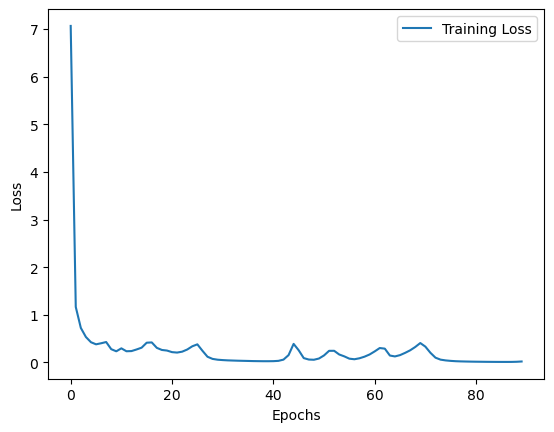

In [41]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(sknn.history[:, 'train_loss'], label = "Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
nn_score = cross_val_score(sknn, X_train, y_train, scoring = 'neg_mean_squared_error')

  epoch    train_loss     dur
-------  ------------  ------
      1        7.3511  0.1405
      2        1.3859  0.1460
      3        0.8691  0.1362
      4        0.6563  0.1367
      5        0.5169  0.1334
      6        0.4166  0.1716
      7        0.3403  0.1848
      8        0.3170  0.1443
      9        0.3307  0.1268
     10        0.4523  0.1269
     11        0.5460  0.1373
     12        0.6118  0.1284
     13        0.5055  0.1420
     14        0.3870  0.1691
     15        0.3832  0.1263
     16        0.3338  0.1233
     17        0.2761  0.1217
     18        0.3140  0.1230
     19        0.4104  0.1418
     20        0.4601  0.1805
     21        0.3284  0.1616
     22        0.1551  0.1286
     23        0.1068  0.1235
     24        0.0819  0.1228
     25        0.0693  0.1234
     26        0.0637  0.1257
     27        0.0587  0.1264
     28        0.0554  0.1247
     29        0.0513  0.1241
     30        0.0483  0.1265
     31        0.0449  0.1302
     32   

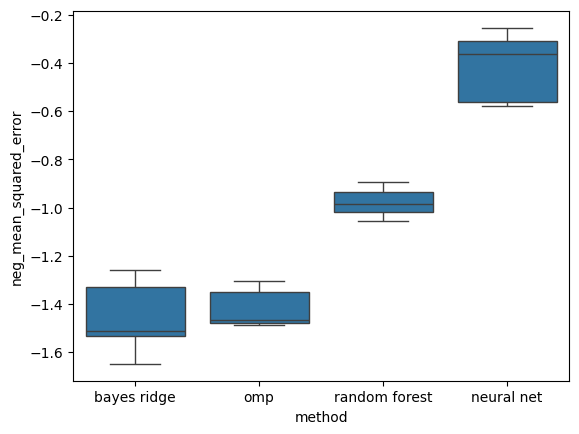

In [43]:
plot_comparison((bayes_ridge_score, omp_score, rf_score, nn_score), ("bayes ridge", "omp", "random forest", "neural net"))

The best neural network with tuned hyperparameters gives much more accurate predictions than the random forst model.

# <center> V/ Creation of the submission

In [44]:
X_test = df_process_test.copy()
X_test.iloc[:, -24:] = X_test.iloc[:, -24:] * lab_factor

In [45]:
x = torch.zeros(X_test.shape[0] * X_test.shape[1]).reshape(X_test.shape[0], X_test.shape[1])


for idx in range(0,X_test.shape[0]):
    row = X_test.iloc[idx]
    x[idx] = ( torch.tensor((row), dtype=torch.float) )


In [47]:
y_pred = sknn.predict(x)

In [49]:
# Convert your list into a DataFrame
df = pd.DataFrame(y_pred)
df['ID']=[x for x in range(1,1376)]
# Rename the column 'old_name' to 'new_name'
df.rename(columns={0: 'RT'}, inplace=True)
df = df[['ID','RT']]


# Save the DataFrame as a CSV file
df.to_csv('SUBMIT_EPOCH_5_final.csv', index=False)  # 'index=False' to not includes the row index

# <center> VI/ Conclusions

After tuning the hyperparameters of both non-linear and linear models, the following observation is clear: a non-linear model, namely a neural network, gives the most accurate predictions of the retention times.

Critical was also the feature engineering step: we observed that adding CDDD features and RDKit features improved performance, and, surprisingly, scaling the one-hot coded lab features by a factor larger than 10 also helped the neural network to make better prediction. The reason might be, that this increases the influence of the lab feature early during training, when the weights are still small, but further analysis would be needed to confirm this.

We did not try other methods that may have led to even better performance, such as dimensionality reduction of the input features with PCA, gradient boosting trees, or ensembling (bagging or boosting) of different models.